# K-Means and GMM demo
*Based on https://tinyheero.github.io/2016/01/03/gmm-em.html, generalized to n classes*

*See also https://davidrosenberg.github.io/ml2015/docs/13.mixture-models.pdf*

As our demos to K-Means and GMMs are not yet on our demo site https://lecture-demo.ira.uka.de/, I made this notebook to give you an interactive demo to see these two algorithms in action.

In [65]:
import scipy
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

means = [[2, 3], [5, 5], [2, 6], [6, 8]]
stddevs = [[1, 1], [0.5, 2], [0.7, 1.8], [0.6, 0.8]]
correlations = [0, 0.2, -0.7, 0.2]
covariances = [np.array([[sigma1**2, rho*sigma1*sigma2], [rho*sigma1*sigma2, sigma2**2]]) for (sigma1, sigma2), rho in zip(stddevs, correlations)]
num_samples = [40, 100, 30, 10]
num_classes = len(num_samples)
datapoints = [np.random.multivariate_normal(mu, sigma, n) for mu, sigma, n in zip(means, covariances, num_samples)]

First of all, we generate some data. We're going to be so nice as to actually generate the data with a Gaussian distribution. In the real world, we might be trying to fit a GMM to data that is not actually Normal-distributed.

The d-variate Gaussian distribution is defined as

$$\frac{1}{\sqrt{(2\pi)^d|\Sigma|}}\exp\left(-\frac{1}{2}(x-\mu)^\top\Sigma^{-1}(x-\mu)\right)$$

Where $|\sigma|$ is the determinant of $\Sigma$. Note that above we use a parametrization of the bivariate normal distribution with the parameters $\mu$, $\sigma_1$, $\sigma_2$ and $\rho$. We can convert this as follows:

$$\Sigma = \begin{bmatrix} \sigma_1^2 & \rho\sigma_1\sigma_2 \\
                           \rho\sigma_1\sigma_2 & \sigma_2^2 \end{bmatrix}$$

Next, we plot the data with the classes. The ellipses show the $3\sigma$ limit.

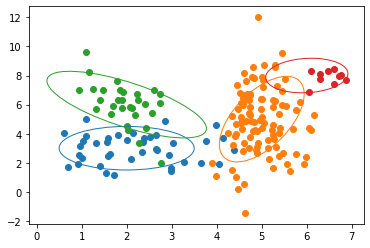

In [66]:
def gaussian(x, mu, sigma):
    return 1 / (np.sqrt((2 * np.pi) ** len(x)) * np.linalg.det(sigma)) * \
        np.exp(-0.5 * np.dot((x - mu).T, np.dot(np.linalg.inv(sigma), x - mu)))
    
def plot_gaussian(mu, sigma, c=None):
    sigma1 = np.sqrt(sigma[0, 0])
    sigma2 = np.sqrt(sigma[1, 1])
    rho = sigma[0, 1] / (sigma1 * sigma2)
    ellipse = Ellipse(mu, 3*sigma1, 3*sigma2, np.arctan(-rho) / 2 / np.pi * 360, ec=c, fill=False)
    ax = plt.gca()
    ax.add_patch(ellipse)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(num_classes):
    plot = plt.scatter([x for x,y in datapoints[i]],
                       [y for x,y in datapoints[i]])
    plot_gaussian(means[i], covariances[i], colors[i])

Now to make sure that there isn't any cheating, we throw away the labels and existing clustering, putting all our generated points into a single list.

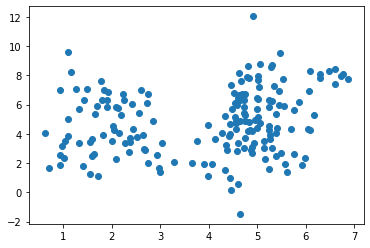

In [67]:
# Oops, we lost the labels!
del means, stddevs, correlations, num_samples
datapoints = np.concatenate(datapoints)
plt.scatter(datapoints[:, 0], datapoints[:, 1])

Next, we define the K-means algorithm. In this algorithm, we maintain K clusters, each defined by their center point. There are different algorithms to train K-means, we will use the simplest one.
We iterate two steps:
1. Assign each datapoint to the cluster with the closest center point.
2. Redefine the centers to the mean of all points in that cluster.
We repeat until the clusters don't change anymore. In my example, I made the algorithm a Python iterator, so you can see the output at each step and just run as long as you like.

We initialize the algorithm by choosing random data points for the inital means. Another option would be to subdivide the data randomly, then begin at step 2.

In [73]:
def kmeans(data, num_classes):
    means = data[np.random.randint(len(data), size=num_classes)]
    
    while True:
        clusters = [[] for _ in range(num_classes)]
        for point in data:
            min_i = -1
            min_distance = float("inf")
            for i, mean in enumerate(means):
                distance = (point[0] - mean[0]) ** 2 + (point[1] - mean[1]) ** 2
                if distance < min_distance:
                    min_i = i
                    min_distance = distance
            clusters[min_i].append(point)
        yield clusters, means
        means = [np.mean(cluster, axis=0) for cluster in clusters]

In [74]:
algorithm = kmeans(datapoints, num_classes)  # To restart the algorithm, run this part

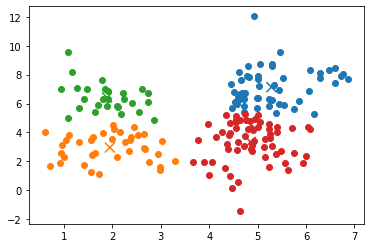

In [97]:
# Keep rerunning this until satisfied
kmeans_clusters, means = next(algorithm)
for cluster in kmeans_clusters:
    plt.scatter([x for x,y in cluster],
                [y for x,y in cluster])
plt.scatter([x for x,y in means],
            [y for x,y in means],c=colors[:len(means)], marker="x", s=100)

Probably the result is already not too bad except for the small cluster in the top right. Note that the colors will probably different, as the order of clusters is different from our initial assignment.

One problem with K-Means is that it effectively recognized only spherical clusters. In general, we want to be able to also cluster data with elliptic clusters. For this, we turn to the Gaussian Mixture Model.

In a GMM, we express the distribution of the data as a mix of K Gaussians:

$$P(x)=\sum_{k=1}^K \alpha_k \mathcal{N}(x|\mu_k, \Sigma_k)$$

Where $\mathcal{N}$ is the multivariate normal distribution parameterized by $\mu_k$ and $\Sigma_k$, which we will learn. In addition, we learn $\alpha_k$, the prior probability of a point coming from a given class. Note that it is a common misconception that in a Gaussian Mixture model we represent a class as a mixture of Gaussians. This is not true. Each class is one Gaussian distribution. The data in total is represented as a mixture of Gaussians, one for each class.

Like for K-means, there are different algorithms to train GMMs. We will use the Expectation Maximization (EM) algorithm (which is not unique to GMMs). 

We alternate between the Expectation (E) step and the Maximisation (M) step.

In the Expecation step, we calculate the expectation values for the class memberships of the data points using Bayes:

$$P(\omega_k|x)=\frac{P(\omega_k)P(x|\omega_k)}{P(x)}=\frac{P(\omega_k)P(x|\omega_k)}{\sum_i^K P(\omega_i)P(x|\omega_i)}$$

Where

$$P(\omega_k)=\alpha_k\qquad P(x|\omega_k)=\mathcal{N}(x|\mu_k, \Sigma_k)$$

Then in the maximisation step, we re-estimate our values for $\alpha_k, \mu_k$ and $\Sigma_k$. But instead of using the hard class assignments like in K-Means, we use the "soft" assignments $P(\omega_k|x)$ as weights. Effectively, we consider each datapoint to be in all classes with a certain weight.

Consider the calculation for $\mu_k$:

$$\mu_k = \frac{\sum_n^N P(\omega_k|x_n)x_n}{\sum_n^N P(\omega_k|x_n)}$$

In K-Means, each sample had a weight of either 0 or 1, depending on whether it belongs to class $k$ or not. Now each sample has a weight equal to $P(\omega_k|x)$, because we have soft assignments.

The other parameters are adjusted as follows:

$$\begin{align}
\Sigma_k &= \frac{\sum_n^N P(\omega_k|x_n)(x_n - \mu_k)^\top(x_n - \mu_k)}{\sum_n^N P(\omega_k|x_n)}\\
\alpha_k &= \frac{\sum_n^N P(\omega_k|x_n)}{N}
\end{align}$$

In order to evaluate the quality of our model, we use the likelihood, the probability that the data was produced by this model:

$$L(X)=\prod_{n=1}^N P(x_n) = \prod_{n=1}^N \sum_{k=1}^K \alpha_k \mathcal{N}(x_n|\mu_k, \Sigma_k)$$

In this case, we use the log Likelihood for numerical reasons:

$$\log L(x)=\log \prod_{n=1}^N P(x_n) = \sum_{n=1}^N \log P(x_n)$$

Note that in the code below, some operations are vector operations. I've tried to keep it to a minimum to improve readability, but in some cases, a vector operations might be easier to understand than an iteration.

We need some initialization, and GMMs can be quite sensitive to a good initialization. So we use the final output from K-Means above.

In [198]:
def gmm_em(initial_clusters):
    num_classes = len(initial_clusters)
    num_points = sum(len(cluster) for cluster in initial_clusters)
    means = [np.mean(cluster, axis=0) for cluster in initial_clusters]
    covariances = [np.mean([np.outer(point - means[i], point - means[i]) for point in cluster[i]], axis=0)
                   for i in range(num_classes)]
    priors = [len(cluster) / num_points for cluster in initial_clusters]
    points = np.concatenate(initial_clusters)
    while True:
        # E: Expectation
        posterior_probabilities = np.zeros((num_points, num_classes))
        observation_probabilities = np.zeros(num_points)
        for i, point in enumerate(points):
            class_probabilities = np.zeros(num_classes)
            for j, (mean, covariance) in enumerate(zip(means, covariances)):
                class_probabilities[j] = gaussian(point, mean, covariance)
            observation_probabilities[i] = sum(priors * class_probabilities)
            posterior_probabilities[i] = priors * class_probabilities / observation_probabilities[i]
        
        log_likelihood = sum(np.log(observation_probabilities))
        
        # Classify:
        class_indices = np.argmax(posterior_probabilities, axis=1)
        clusters = [[] for _ in range(num_classes)]
        for i, point in enumerate(points):
            clusters[class_indices[i]].append(point)
        yield clusters, log_likelihood, (priors, means, covariances)
        
        # M: Maximization
        class_weights = np.sum(posterior_probabilities, axis=0)
        means = [sum(posterior_probabilities[i, k] * points[i] for i in range(num_points))
                 / class_weights[k]
                 for k in range(num_classes)]
        covariances = [sum(posterior_probabilities[i, k] * np.outer(points[i] - means[k], points[i] - means[k]) for i in range(num_points))
                       / class_weights[k]
                       for k in range(num_classes)]
        priors = [class_weights[k] / num_points for k in range(num_classes)]
        

In [200]:
algorithm = gmm_em(kmeans_clusters) # Run this to restart the algorithm

-657.13704129


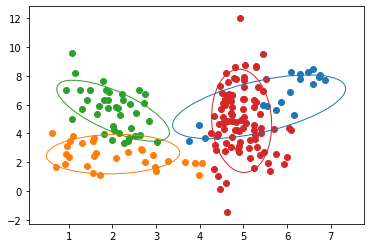

In [303]:
# Keep rerunning here until satisfied
gmm_clusters, log_likelihood, (priors, means, covariances) = next(algorithm)
print(log_likelihood)
for k in range(num_classes):
    plt.scatter([x for x,y in gmm_clusters[k]],
                [y for x,y in gmm_clusters[k]])
    plot_gaussian(means[k], covariances[k], colors[k])

That's it. Note that neither algorithm is guaranteed to converge to a global optimum.

Expectation Maximisation is the first example in the lecture of applying Maximum Likelihood estimation to a problem where a closed-form solution doesn't exist. MLE is the basis for many current machine learning algorithms (including neural networks) and iterative procedures like EM are very often necessary.